In [2]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from time import gmtime, strftime
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import json
features = [
  'delivery_type', 'total_size', 'distance', 
  'lat', 'long', 'task_around', 
  'city', 'total_task', 'cost',
  
  'pickup_effective_dt', 'delivery_dt',
]
stad_cols = [
  'total_size', 'distance',
  'task_around', 'cost'
]
stad_cols_2 = [
  'lat', 'long',
]
stad_dates = [
  'delivery_dt', 'pickup_effective_dt'
]
#'pickup_effective_dt',
target = 'delivery_effective'
RANDOM = 2408
RESULTS = './results.csv'

In [2]:
class display(object):
  """Display HTML representation of multiple objects"""
  template = """<div style="float: left; padding: 10px;">
  <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
  </div>"""
  def __init__(self, *args):
    self.args = args

  def _repr_html_(self):
    return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)

  def __repr__(self):
    return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

def save_params(scalers, metrics):
  metrics_values = []
  for value in metrics.values():
    metrics_values.append(str(value))
  metada = []
  for key, value in scalers.items():
    metada.append({ key: value })
  with open(RESULTS, 'a') as f:
    f.write(f'{",".join(metrics_values)},{metada}\n')

def evaluate(y_test, y_pred, dataframe, threshold=1, save=False):
  pred_bool = np.where(dataframe['pred'] > dataframe['delivery_effective'], True, False)
  test_bool = np.where(dataframe['delivery_effective'] > dataframe['delivery_dt'], True, False)
  f1_pres = f1_score(test_bool, pred_bool)

  delta_pred_bool = (dataframe['pred'] - dataframe['delivery_effective']).dt.total_seconds() / 3600
  delta_pred_bool = np.where(delta_pred_bool > threshold, True, False)
  delta_test_bool = (dataframe['delivery_effective'] - dataframe['delivery_dt']).dt.total_seconds() / 3600
  delta_test_bool = np.where(delta_test_bool > threshold, True, False)

  f1_delta = f1_score(delta_pred_bool, delta_test_bool)  
  mae = mean_absolute_error(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)

  if save:
    save_params({
      'threshold'  : threshold,
      'features'    : features,
      'stad_cols'   : scaler.get_params(deep=True),
      'stad_cols_2' : scaler_2.get_params(deep=True),
      'stad_dates'  : scaler_3.get_params(deep=True)
    },{
      'MAE' : mae,
      'MAPE': mape,
      'RMSE': rmse,
      'R2'  : r2,
      'f1_pres' : f1_pres,
      'f1_delta'  : f1_delta
    })
  print(
    '{0:10s}: {1}\n{2:10s}: {3}\n{4:10s}: {5}\n{6:10s}: {7}\n{8:10s}: {9}\n{10:10s}: {11}'.format(
    'MAE', mae, 'MAPE', mape, 'RMSE', rmse, 'r2', r2, 'f1 (press)', f1_pres, f'f1 (D {threshold})', f1_delta
  ))

In [3]:
df = pd.read_pickle("../data/shippify_icd_task_new.pkl", compression='gzip')
delta_times = (df['delivery_effective'] - df['delivery_dt']).dt.total_seconds() / 3600
df.delivery_type = df.delivery_type.astype('category').cat.codes
df.total_size = df.total_size.astype('category').cat.codes

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226828 entries, 0 to 251822
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   id                   226828 non-null  object             
 1   route_id             223343 non-null  object             
 2   creation_date        226828 non-null  datetime64[ns, UTC]
 3   delivery_type        226828 non-null  int8               
 4   city                 226828 non-null  int8               
 5   cost                 226828 non-null  float64            
 6   total_size           226828 non-null  int8               
 7   distance             226828 non-null  float64            
 8   company_id           226828 non-null  int64              
 9   company_type         226828 non-null  int64              
 10  network_id           226828 non-null  int16              
 11  pickup_dt            226828 non-null  datetime64[ns, UTC]
 12  pi

In [3]:
df = pd.read_pickle("../data/shippify_icd_task_new.pkl", compression='gzip')
dailyDeliveries = pd.to_datetime(df['pickup_effective_dt']).dt.floor('d').value_counts()
def getDailyDeliveriesByDate(date):
    return dailyDeliveries[pd.to_datetime(date).floor('d')]

In [4]:
df['total_task'] = df['pickup_effective_dt'].apply(getDailyDeliveriesByDate)

In [5]:
df.total_task

0         3396
1         2711
2         3668
4         3022
5         3194
          ... 
251818    3081
251819    3721
251820    2790
251821    2833
251822    3468
Name: total_task, Length: 226828, dtype: int64

In [15]:
# revisar convercion a timestamp de estas 3 columns
df.delivery_dt = df.delivery_dt.view('i8') / 1e9
df.delivery_effective = df.delivery_effective.view('i8') / 1e9
df.pickup_effective_dt = df.pickup_effective_dt.view('i8') / 1e9

In [16]:
scaler = MinMaxScaler(feature_range=(0, 10))
df[stad_cols] = scaler.fit_transform(df[stad_cols])

scaler_2 = MinMaxScaler(feature_range=(0, 10))
df[stad_cols_2] = scaler_2.fit_transform(df[stad_cols_2])

scaler_3 = MinMaxScaler(feature_range=(0, 100))
df[stad_dates] = scaler_3.fit_transform(df[stad_dates])
save_df = True
if save_df:
  df.to_csv('../data/shippify_vertex_std_2.csv', index=False)

In [121]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.25, random_state=2408)

model = LinearRegression()
reg = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [122]:
threshold = 1
# Restore scale and type columns
X_test['pred'] = y_pred * 1e9
X_test['delivery_effective'] = y_test * 1e9
X_test[stad_dates] = scaler_3.inverse_transform(X_test[stad_dates]) * 1e9

X_test.delivery_dt = X_test.delivery_dt.astype('datetime64[ns]')
X_test.delivery_effective = X_test.delivery_effective.astype('datetime64[ns]')
X_test.pred = X_test.pred.astype('datetime64[ns]')

# Calculate delta
X_test['delta'] = (X_test['delivery_effective'] - X_test['pred']).dt.total_seconds() / 3600

evaluate(y_test, y_pred, X_test, threshold, False)

MAE       : 14562.920855517968
MAPE      : 9.130374782906435e-06
RMSE      : 60948.5855490981
r2        : 0.9993005340282224
f1 (press): 0.7087508187971565
f1 (D 1)  : 0.5508304273302204


En general, en términos de precisión estan bastante cerca, incluso un poco mejor que el modelo generaod por Vertex. En términos de predicción de ALERTAS, estamos seguros en un 70% de que una entrega llegara atrasada con respecto a su tiempo teorico. Sin embargo, cuando la alerta se debe lanzar solo cuando la entrega llegaría una hora después de su hora teorica, nuestra precisión baja a un 55%.

Esto se debe a que cuando la alerta se debe lanzar con un DELTA establecido, el modelo debe ser mas preciso en su predición en el futuro.

True     127079
False     99749
dtype: int64


<AxesSubplot:ylabel='Density'>

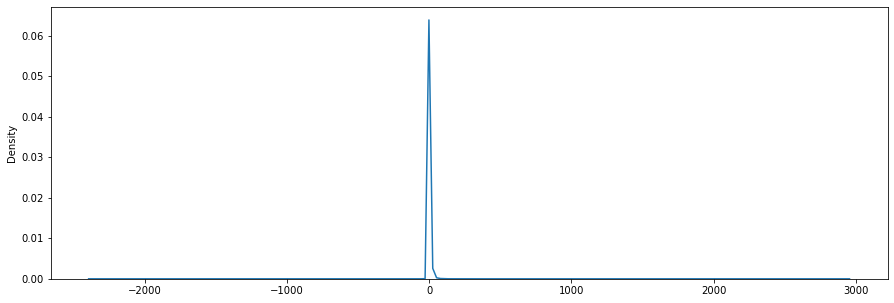

In [123]:
dft = pd.read_pickle("../data/shippify_icd_task_new.pkl", compression='gzip')
delta_times = (dft['delivery_effective'] - dft['delivery_dt']).dt.total_seconds() / 3600
delta_times_bool = np.where(delta_times >  threshold, True, False)
print(pd.DataFrame(delta_times_bool).value_counts())
plt.figure(figsize=(15,5))
plt.tight_layout()
sns.kdeplot(data=delta_times)

In [124]:
(dft['delivery_effective'] - dft['delivery_dt']).dt.total_seconds() / 3600

0        -0.912222
1        -1.013889
2         0.646111
4        -0.281944
5        -0.106111
            ...   
251818   -2.942500
251819   -1.057500
251820    0.968611
251821    1.616944
251822   -0.895556
Length: 226828, dtype: float64

In [125]:
#print(X_test[ X_test['delta'] > 20 ].describe())
X_test[ X_test['delta'] > 24 ]

,delivery_type,total_size,distance,lat,long,task_around,city,total_task,cost,pickup_effective_dt,delivery_dt,pred,delivery_effective,delta
97487,1,2.5,0.052777,8.340606,0.241332,3.869969,3,226828,0.428571,1.597254e+18,2020-08-12 13:30:45,2020-08-12 23:44:29.598186752,2020-08-14 02:29:38,26.752334
154803,1,10.0,0.064637,7.669014,0.152544,0.072239,3,226828,0.427103,1.595600e+18,2020-07-24 20:08:29,2020-07-24 18:46:05.595408128,2020-07-27 16:42:41,69.943168
99428,1,2.5,0.092804,8.854095,0.306697,1.661507,3,226828,0.428571,1.592256e+18,2020-06-15 18:30:00,2020-06-16 03:08:19.240561920,2020-06-18 01:46:05,46.629378
219498,1,2.5,0.021644,8.374022,0.180635,1.104231,3,226828,0.000000,1.595891e+18,2020-07-28 14:00:00,2020-07-28 04:22:18.700544000,2020-07-29 17:05:21,36.717305
203928,1,2.5,0.120971,7.305906,0.242702,0.464396,3,226828,0.571429,1.595356e+18,2020-07-21 16:00:00,2020-07-22 03:04:49.766978048,2020-07-23 22:41:16,43.607287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212218,1,10.0,0.082130,7.708852,0.247210,0.701754,3,226828,0.662857,1.595005e+18,2020-07-17 16:30:00,2020-07-17 21:24:05.273750528,2020-07-21 16:43:31,91.323813
169854,1,2.5,0.053963,8.634946,0.210182,0.464396,3,226828,0.571429,1.595260e+18,2020-07-20 16:00:00,2020-07-20 21:44:49.067385856,2020-07-21 22:15:18,24.508037
153584,1,2.5,0.116524,7.428021,0.243826,0.206398,3,226828,0.571429,1.591380e+18,2020-06-05 16:00:00,2020-06-06 02:36:19.538973440,2020-06-08 21:11:18,66.582906
52646,1,2.5,0.130459,7.258983,0.262582,0.154799,3,226828,0.571429,1.595282e+18,2020-07-20 16:00:00,2020-07-21 06:56:32.932860416,2020-07-22 23:46:41,40.835574


In [126]:
X_test[ X_test['delta'] < 24 ]

,delivery_type,total_size,distance,lat,long,task_around,city,total_task,cost,pickup_effective_dt,delivery_dt,pred,delivery_effective,delta
208501,1,10.0,0.091914,8.924799,0.285447,0.804954,3,226828,0.884380,1.591646e+18,2020-06-08 20:00:23,2020-06-08 22:38:20.308818688,2020-06-08 22:16:36,-0.362308
134497,0,2.5,0.000000,9.035980,0.179106,0.061920,3,226828,0.891429,1.598640e+18,2020-08-29 00:11:14,2020-08-28 20:49:38.682671104,2020-08-28 21:47:49,0.969533
167731,1,2.5,0.029353,8.684444,0.250028,2.394221,3,226828,0.313811,1.595272e+18,2020-07-20 21:03:53,2020-07-21 00:15:59.175181568,2020-07-20 19:45:01,-4.516160
80528,1,2.5,0.061079,8.527639,0.245521,4.798762,3,226828,0.428571,1.592484e+18,2020-06-18 13:30:36,2020-06-18 18:19:39.540456704,2020-06-18 16:26:09,-1.891817
114849,1,2.5,0.052480,8.317463,0.245840,2.683179,3,226828,0.428571,1.595080e+18,2020-07-18 14:00:00,2020-07-18 19:42:25.799337216,2020-07-18 16:12:34,-3.497722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75697,1,2.5,0.047143,7.962079,0.248898,0.970072,3,226828,0.428571,1.591624e+18,2020-06-08 14:00:00,2020-06-08 20:11:39.632560128,2020-06-08 19:39:54,-0.529342
171502,1,10.0,0.039731,8.081619,0.137650,0.309598,3,226828,0.386286,1.597245e+18,2020-08-12 16:00:00,2020-08-12 18:58:36.476571648,2020-08-12 17:42:58,-1.260688
217302,0,2.5,0.021941,8.631097,0.265401,2.270382,3,226828,0.640000,1.596219e+18,2020-07-31 20:06:54,2020-07-31 21:03:56.381596160,2020-07-31 19:40:09,-1.396495
240371,0,2.5,0.018383,8.519917,0.160994,0.743034,3,226828,0.388571,1.596124e+18,2020-07-30 16:14:47,2020-07-30 19:26:31.216530944,2020-07-30 16:34:59,-2.858949


<AxesSubplot:xlabel='delta', ylabel='Density'>

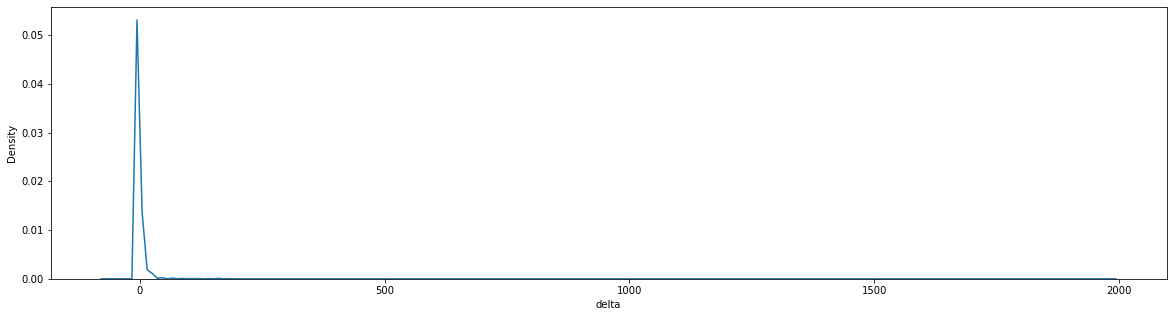

In [128]:
%matplotlib inline
plt.figure(figsize=(20,5))
sns.kdeplot(data=X_test['delta'])